In [1]:
__author__ = 'Fiona C. Pärli'
__email__ = 'fiona.paerli@students.unibe.ch'
__date__ = 'June 2025'

# Monte Carlo Integral
1) Test case with integral of $x^2$:   
$$\int_0^1 x^2 dx = 1/3$$
2) Angular integral

$$I(\alpha) = \int \frac{d\Omega_q }{4\pi} \frac{n_i \cdot n_j}{n_1 \cdot n_q \; n_2 \cdot n_q} \Theta_{out}(\alpha)$$
with $n_1^\mu = (1,1,0,0)$ and $n_2^\mu = (1, -1, 0, 0)$. Use $n_q = (1, \cos \theta, \sin \theta \cos \phi, \sin \theta \sin \phi)$.

The integral turns into: 
$$\int \frac{d \Omega}{4 \pi} \Theta(\alpha) = \frac{1}{4 \pi} \int_{\alpha}^{\pi - \alpha} d\theta \sin \theta \int_0^{2\pi} d \phi$$

- Analytical calculation (see separate document)
- Direct Monte Carlo Integral
- Monte Carlo Integral after the variable transformation from $\theta$ to $y$:
$$y = \frac{1}{2}\log \left( \frac{1 + \cos \theta}{1 - \cos \theta}\right)$$


In [ ]:
import numpy as np
import monte_carlo 

res, error = monte_carlo.monte_carlo_integrator(monte_carlo.test_func, 0, 1, num_samples = 100_000)
print(f"First test integral of x^2: {res:.4f}, error: {error:.4f}")

n1 = np.array([1, 1, 0, 0])
n2 = np.array([1, -1, 0, 0])

integral, error = monte_carlo.angle_integral(n1, n2, np.radians(60))
print(f"Angular intgeral, no variable transformation: {integral:.10e} $\\pm$ {error:.10e}")

integral, error = monte_carlo.transformed_angle_integral(n1, n2, np.radians(60))
print(f"Angular intgeral, with variable transformation: {integral:.10e} $\\pm$ {error:.10e}")

ana_res = monte_carlo.analytical_res(np.radians(60))
print(f"Analytical result: {ana_res}")

First test integral of x^2: 0.3310, error: 0.0009
Angular intgeral, no variable transformation: 2.1983325075e+00 $\pm$ 6.0245483557e-04


# Toy Model
$$\frac{d}{dt} H_2(t) = - H_2(t) V_2$$
$$\frac{d}{dt}H_m(t) = -H_m(t) V_m + H_{m-1}(t) R_{m-1}, \qquad m \geq 3$$

We use (later to be replaced) $V_m = \alpha \cdot m$ and $R_m = \alpha \cdot V_m$ where $\alpha \leq 1$. The initial conditions are $H_2(0) = h$ and $H_m(0) = 0$, m \geq 3. We use the Monte Carlo method to solve
the integral
$$H_m(t) = \int_0^t dt' H_{m-1}(t') \exp \left( -(t- t')V_m \right)$$

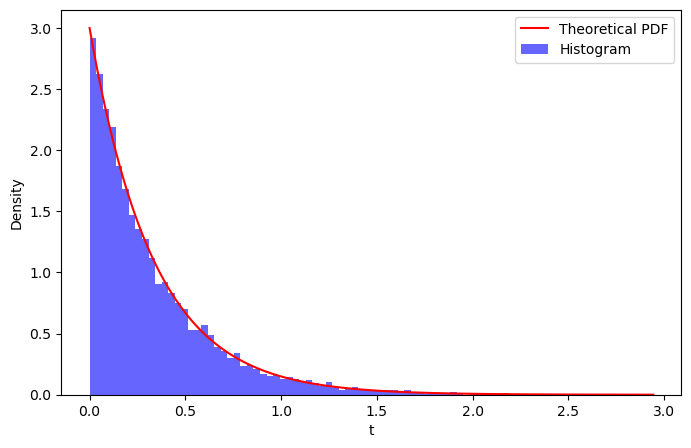

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

def random_t(V_m: int, num_samples: int = 10_000):
    """exercise 

    Args:
        V_m (int): virtual correction placeholder
        num_samples (int, optional): Number of Monte Carlo iterations. Defaults to 10_000.
    """
    z = np.random.uniform(0, 1, num_samples)
    t = -1 / V_m * np.log(z)

    plt.figure(figsize=(8, 5))
    
    #theoretical pdf
    t_sorted = np.sort(t)
    plt.plot(t_sorted, V_m * np.exp(-V_m * t_sorted), color="r", label="Theoretical PDF")

    # sample hist
    plt.hist(t, bins="auto", density=True, alpha=0.6, color="b", label="Histogram")

    plt.xlabel("t")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

#Exercise: Generate random numbers z between 0 and 1, make a histogram with t = -1/V_m ln(z), V_m = 3
random_t(V_m = 3)

KeyboardInterrupt: 

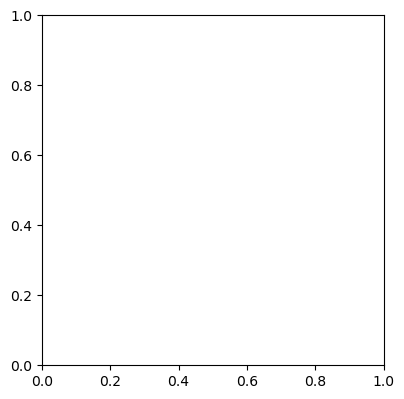

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import monte_carlo

# Exercise: Solve the DGLs with Monte Carlo methods
alpha = 0.5
h = 1.0  # Initial condition for H_2, H_2(0) = h
m_max = 10
t_max = 10
num_samples = 10000
times = np.linspace(0, t_max, 100)  # Time grid from 0 to t_max

# Dictionary to store H_m values on the time grid, m values are the keys
H_vals = {}

# H_2 is already known
V_2 = alpha  # V_2 = 2 * alpha
H_vals[2] = h * np.exp(-2*V_2 * times)


# Compute numerical all-order sum from H_m values
def numerical_all_order_sum(H_vals, times, m_max):
    S_vals = np.zeros_like(times)
    for m in range(2, m_max + 1):
        S_vals += H_vals[m]
    return S_vals

# For m >= 3, compute H_m(t) using the following integral. Due to H_m(0) = 0 for m>2 there is only one term.
# H_m(t) = ∫_0^t H_{m-1}(tau) * V_m * (m-1) * exp(-V_m * (t - tau)) dtau
for m in range(3, m_max + 1):
    H_vals[m] = np.zeros_like(times)
    V_m = alpha*m  # V for m is m
    R = alpha  # R
    for i, t in enumerate(times):
        if t == 0:
            H_vals[m][i] = 0
        else:
            def integrand(tau):
                H_m_minus_1 = np.interp(tau, times, H_vals[m - 1])  # Interpolate H_{m-1}(tau)
                return H_m_minus_1 * R * np.exp(-V_m * (t - tau)) 

            integral, err = monte_carlo.monte_carlo_integrator(integrand, 0, t, num_samples)
            H_vals[m][i] = integral

# Function to plot numerical vs analytical solutions for each n
def plot_comparison():
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    n_values = [2, 3, 4, 5, 10]

    for i, n in enumerate(n_values):
        ax = axes[i // 3, i % 3]
        
        # Numerical solution
        numerical_solution = H_vals.get(n, np.zeros_like(times))
        
        V = alpha  
        R = alpha
        analytical_solution = np.array([monte_carlo.toy_model_sol(n, t, V, R) for t in times])
        
        ax.plot(times, numerical_solution, label=f"Numerical H_{n}(t)", linestyle='-', color='blue')
        ax.plot(times, abs(analytical_solution), label=f"Analytical H_{n}(t)", linestyle='--', color='red')
        ax.set_xlabel("t")
        ax.set_ylabel(f"$H_{n}(t)$")
        ax.set_title(f"Comparison for n = {n}")
        ax.legend()

    # Plot for all-order sum
    ax_all_order = axes[1, 2]  
    V = alpha 
    R = alpha

    # Analytical all-order sum
    all_order_values = np.array([monte_carlo.all_order_sum(t, V, R) for t in times])
    # Numerical all-order sum
    numerical_sum = numerical_all_order_sum(H_vals, times, m_max)
    
    ax_all_order.plot(times, all_order_values, label="Analytical all-order sum", linestyle='--', color='orange')
    ax_all_order.plot(times, numerical_sum, label="Numerical all-order sum", linestyle='-', color="#0BB0E7")
    ax_all_order.set_xlabel("t")
    ax_all_order.set_ylabel("All-order sum")
    ax_all_order.set_title("All-order sum solution")
    ax_all_order.legend()

    plt.tight_layout()
    plt.show()


plot_comparison()
